# Training stress calculations on aggregate and disaggregate data using the heart rate dynamics model

This last notebook develops a simple model to estimate TRIMP (TRaining IMPulse) scores using aggregate metrics. We will then compare this simple model performance with the heart rate predictions of our final model from notebook **4. Modelling.ipynb**. From our predictions we can directly calculate the TRIMP metrics. In particular we will look at the TRIMP Points and eTRIMP (Edwards TRIMP) metrics.

Edwards TRIMP was calculated by multiplying the time spent in five HR zones by a corresponding coefficient (50–60% HRmax = 1; 60–70% HRmax = 2; 70–80% HRmax = 3; 80–90% HRmax = 4; and 90–100% HRmax = 5), the results of which were then summed. See **Literature** for more information.

TRIMP: the original Morton/Banister with Green et al coefficient. See **Literature** for more information.

TRIMP = time × HR ratio × 0.64 × exp(sex factor × HR ratio)

where sex factor = 1.92 if male, or 1.67 if female and

HR ratio = (average HR − resting HR) / (maximum HR − resting HR)

We define here our holdout period for the internal training load prediction

In [398]:
date_start_holdout = '2020-09-01'

### Import libraries

In [259]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.options.display.max_rows = 999

import pickle

import numpy as np

import warnings
warnings.filterwarnings('ignore')

from datetime import datetime

import json

# statistics
import phik

# modelling
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# visualisations
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

Read in our modelset. We want to use the same training files and holdout files

From the this file we will calculate the TRIMP and Edwards TRIMP for both the actual heart rate and the predictions based on our heart rate prediction

In [425]:
# read in model predictions from notebook 4. Modelling.ipynb
df_heart_rate_predictions = pd.read_pickle('df_heart_rate_predictions.pkl')

In [426]:
# Define some parameters which will be used for TRIMP calculations. These are (1) rider max heart rate and rider min heart rate (rest heart rate) and (2) 2 TRIMP factors

# (1) Read in our rider configuration file (see explanation noteboook '0. Data exploration.ipynb')

with open('rider_config.json', 'r') as c:
   rider_params = json.load(c)["rider_params"]

# (2) define the factors for TRIMP

male = 1.92 # 1.67 if female
trimp_weight_factor = 0.64

In [427]:
# add variables to determine heart rate zone based on predicted and actual data

col_pred         = 'pred_hr'
conditions  = [(df_heart_rate_predictions[col_pred]> 0.5*rider_params['rider_max_hr']) & (df_heart_rate_predictions[col_pred]<= 0.6*rider_params['rider_max_hr']), 
               (df_heart_rate_predictions[col_pred]> 0.6*rider_params['rider_max_hr']) & (df_heart_rate_predictions[col_pred]<= 0.7*rider_params['rider_max_hr']), 
               (df_heart_rate_predictions[col_pred]> 0.7*rider_params['rider_max_hr']) & (df_heart_rate_predictions[col_pred]<= 0.8*rider_params['rider_max_hr']),
               (df_heart_rate_predictions[col_pred]> 0.8*rider_params['rider_max_hr']) & (df_heart_rate_predictions[col_pred]<= 0.9*rider_params['rider_max_hr']),
               (df_heart_rate_predictions[col_pred]> 0.9*rider_params['rider_max_hr'])]
zones_pred     = [ 1, 2, 3, 4, 5 ]

df_heart_rate_predictions["zone_predicted"] = np.select(conditions, zones_pred, default=0)

col_act         = 'hr'
conditions  = [(df_heart_rate_predictions[col_act]> 0.5*rider_params['rider_max_hr']) & (df_heart_rate_predictions[col_act]<= 0.6*rider_params['rider_max_hr']), 
               (df_heart_rate_predictions[col_act]> 0.6*rider_params['rider_max_hr']) & (df_heart_rate_predictions[col_act]<= 0.7*rider_params['rider_max_hr']), 
               (df_heart_rate_predictions[col_act]> 0.7*rider_params['rider_max_hr']) & (df_heart_rate_predictions[col_act]<= 0.8*rider_params['rider_max_hr']),
               (df_heart_rate_predictions[col_act]> 0.8*rider_params['rider_max_hr']) & (df_heart_rate_predictions[col_act]<= 0.9*rider_params['rider_max_hr']),
               (df_heart_rate_predictions[col_act]> 0.9*rider_params['rider_max_hr'])]
zones_act     = [ 1, 2, 3, 4, 5 ]

df_heart_rate_predictions["zone_actual"] = np.select(conditions, zones_act, default=0)

In [435]:
## calculate eTRIMP
df_etrimp_pred = df_heart_rate_predictions.groupby(['filename','zone_predicted']).agg({'pred_hr':'mean', 'filename':'count'}).rename(columns={'filename':'time_sec'}).reset_index()
df_etrimp_act = df_heart_rate_predictions.groupby(['filename','zone_actual']).agg({'hr':'mean', 'filename':'count'}).rename(columns={'filename':'time_sec'}).reset_index()

df_etrimp_pred['eTRIMP_pred_linreg_data'] = df_etrimp_pred['zone_predicted'] * (df_etrimp_pred['time_sec']/60) 
df_etrimp_act['eTRIMP_act_data'] = df_etrimp_act['zone_actual'] * (df_etrimp_act['time_sec']/60) 

# calculate on eTRIMP on filelevel
df_etrimp_pred_file = df_etrimp_pred.groupby('filename').agg({'eTRIMP_pred_linreg_data':'sum'}).reset_index()
df_etrimp_act_file = df_etrimp_act.groupby('filename').agg({'eTRIMP_act_data':'sum'}).reset_index()

# calculate TRIMP points
df_trimp = df_heart_rate_predictions.groupby('filename').agg({'hr':'mean', 'pred_hr':'mean', 'filename':'count'}).rename(columns={'filename':'time_sec'}).reset_index()

# calculate actual and predicted TRIMP points
df_trimp['TRIMP_points_act_data'] = (df_trimp['time_sec']/60) * ((df_trimp['hr'] - resting_HR) / (maximum_HR - resting_HR)) * trimp_weight_factor * np.exp(male * ((df_trimp['hr'] - resting_HR) / (maximum_HR - resting_HR)))
df_trimp['TRIMP_points_pred_linreg_data'] = (df_trimp['time_sec']/60) * ((df_trimp['pred_hr'] - resting_HR) / (maximum_HR - resting_HR)) * trimp_weight_factor * np.exp(male * ((df_trimp['pred_hr'] - resting_HR) / (maximum_HR - resting_HR)))

In [477]:
# create one datafile on ride level regarding TRIMP calculations
df_total_trimp_data = df_trimp.merge(df_etrimp_act_file[['filename','eTRIMP_act_data']], on='filename').merge(df_etrimp_pred_file[['filename','eTRIMP_pred_linreg_data']], on='filename')

Next we read in the activity file which contains aggregated data and merge it to our TRIMP dataset

In [479]:
# read in data
df_activities = pd.read_csv('Activities.csv')

# preprocess some fields
df_activities.columns=df_activities.columns.str.strip()
df_activities.columns=df_activities.columns.str.replace('\s+', '_')

df_activities['date'] = pd.to_datetime(df_activities['date'].apply(lambda x: x.split('/')[0]) + "/" + df_activities['date'].apply(lambda x: x.split('/')[1]) + "/" + df_activities['date'].apply(lambda x: "20" + x.split('/')[2]))

df_activities['filename'] = df_activities.filename.str.replace("json","csv")

# add hour of day as variable (when .30 round back, otherwise to next hour)
df_activities['start_hour_of_day_activity'] = np.where(df_activities.time.apply(lambda x: x.split(':')[1]).astype(int)>30, df_activities.time.apply(lambda x: x.split(':')[0]).astype(int)+1, df_activities.time.apply(lambda x: x.split(':')[0]).astype(int))

# keep only relevant columns
df_activities = df_activities[['date','time','start_hour_of_day_activity','filename','Average_Cadence','Average_Power','BikeScore','Duration','Relative_Intensity',
                               'Nonzero_Average_Power','Time_Moving', 'xPower']]

We merge the two files based on filename and define train and testset (holdout 3 months)

In [480]:
# merge files
df_total = pd.merge(df_activities,df_total_trimp_data, on='filename', how='right')

# split the file for training and testing based on our holdout period

# define holdout set
df_holdout_full = df_total[df_total['date'] >= date_start_holdout]

# define trainset
df_train_full = df_total[df_total['date'] < date_start_holdout]

interval columns not set, guessing: ['TRIMP_points_act_data', 'eTRIMP_act_data', 'Average_Cadence', 'Average_Power', 'BikeScore', 'xPower', 'Duration', 'Relative_Intensity', 'Nonzero_Average_Power']


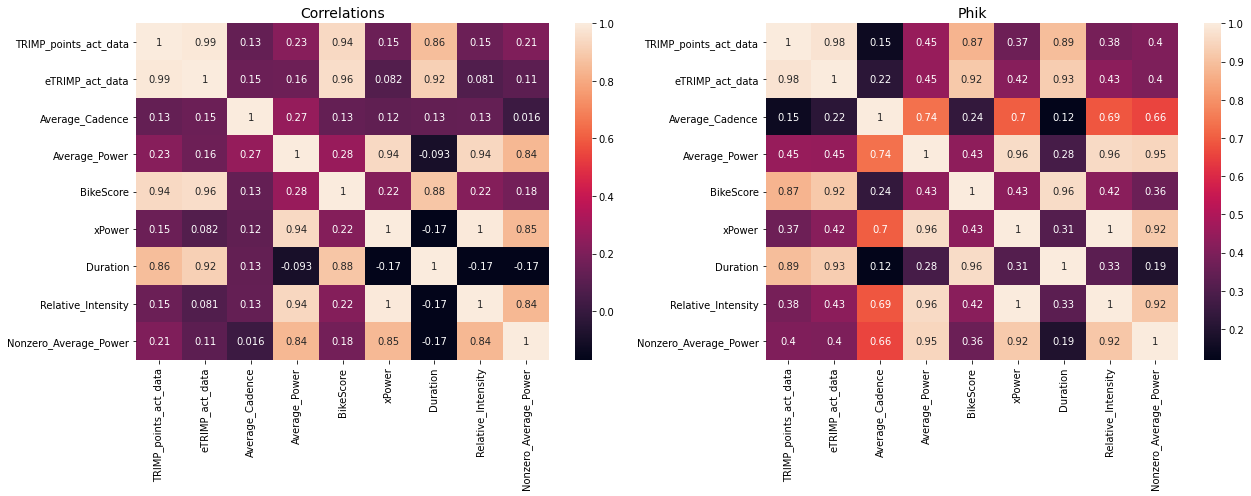

In [481]:
# Make correlation and phik heatmap 

# define columns
cols = ['TRIMP_points_act_data','eTRIMP_act_data','Average_Cadence','Average_Power','BikeScore','xPower','Duration','Relative_Intensity',
                               'Nonzero_Average_Power']

# visualize
fig, ((ax1, ax2)) = plt.subplots(1, 2,figsize=(18,7))

sns.heatmap(df_train_full[cols].corr(), annot=True, ax=ax1);
ax1.set_title('Correlations', fontsize=14);

sns.heatmap(df_train_full[cols].phik_matrix(), annot=True, ax=ax2);
ax2.set_title('Phik', fontsize=14)

plt.tight_layout()

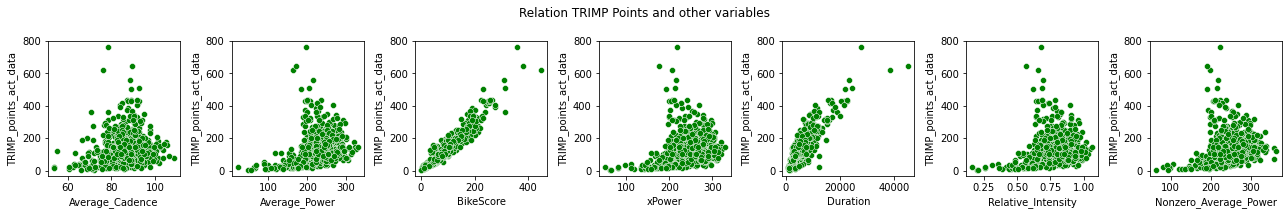

In [482]:
# Visualizing bivariate relations TRIMP points and other variables. We used sns pairplot which code was simpler, but found a bug unfortunately
fig, ((ax1, ax2, ax3, ax4, ax5, ax6, ax7)) = plt.subplots(1, 7,figsize=(18,3))
sns.scatterplot(data=df_train_full, x="Average_Cadence", y="TRIMP_points_act_data", ax=ax1, color='g')
sns.scatterplot(data=df_train_full, x="Average_Power", y="TRIMP_points_act_data", ax=ax2, color='g')
sns.scatterplot(data=df_train_full, x="BikeScore", y="TRIMP_points_act_data", ax=ax3, color='g')
sns.scatterplot(data=df_train_full, x="xPower", y="TRIMP_points_act_data", ax=ax4, color='g')
sns.scatterplot(data=df_train_full, x="Duration", y="TRIMP_points_act_data", ax=ax5, color='g')
sns.scatterplot(data=df_train_full, x="Relative_Intensity", y="TRIMP_points_act_data", ax=ax6, color='g')
sns.scatterplot(data=df_train_full, x="Nonzero_Average_Power", y="TRIMP_points_act_data", ax=ax7, color='g')

plt.suptitle('Relation TRIMP Points and other variables')
fig.subplots_adjust(top=0.91)
plt.tight_layout()

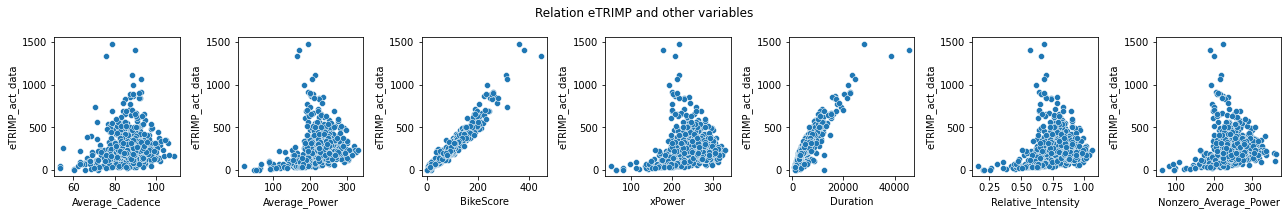

In [483]:
# Visualizing bivariate relations TRIMP Zonal points and other variables. We used sns pairplot which code was simpler, but found a bug unfortunately
fig, ((ax1, ax2, ax3, ax4, ax5, ax6, ax7)) = plt.subplots(1, 7,figsize=(18,3))
sns.scatterplot(data=df_train_full, x="Average_Cadence", y="eTRIMP_act_data", ax=ax1)
sns.scatterplot(data=df_train_full, x="Average_Power", y="eTRIMP_act_data", ax=ax2)
sns.scatterplot(data=df_train_full, x="BikeScore", y="eTRIMP_act_data", ax=ax3)
sns.scatterplot(data=df_train_full, x="xPower", y="eTRIMP_act_data", ax=ax4)
sns.scatterplot(data=df_train_full, x="Duration", y="eTRIMP_act_data", ax=ax5)
sns.scatterplot(data=df_train_full, x="Relative_Intensity", y="eTRIMP_act_data", ax=ax6)
sns.scatterplot(data=df_train_full, x="Nonzero_Average_Power", y="eTRIMP_act_data", ax=ax7)

plt.suptitle('Relation eTRIMP and other variables')
fig.subplots_adjust(top=0.91)
plt.tight_layout()

**Observations** 

We see that in general the linear relations for possible predictors with the heart rate dependent training stress. Let's just build a very simple linear model with Bikescore (which is a training load score related to power) and quite linearly related, Average Power and Average Cadence. We chose these because the other variables all tend to correlate highly of with one of the three we want to include in this simple model.

In [484]:
# We will use all the data. This means that actually we are overfitting. 'In real life' the model would normally drop in performance. But for illustration purposes it is fine for now

# TRIMP regression
lin_reg_TRIMP_Points = LinearRegression()

# TRIMP POINTS
X = df_train_full[['BikeScore','Average_Power','Average_Cadence']]
y = df_train_full['TRIMP_points_act_data']

lin_reg_TRIMP_Points.fit(X, y)

df_train_full['TRIMP_Points_predicted'] = lin_reg_TRIMP_Points.predict(X)
print('RMSE TRIMP Points trainset', (mean_squared_error(df_train_full['TRIMP_points_act_data'],df_train_full['TRIMP_Points_predicted'],squared=False)))
print('R2 TRIMP Points trainset', r2_score(df_train_full['TRIMP_points_act_data'],df_train_full['TRIMP_Points_predicted']))

# eTRIMP regression
lin_reg_eTRIMP = LinearRegression()

X = df_train_full[['BikeScore','Average_Power','Average_Cadence']]
y = df_train_full['eTRIMP_act_data']

lin_reg_eTRIMP.fit(X, y)

df_train_full['eTRIMP_predicted'] = lin_reg_eTRIMP.predict(X)
print('RMSE eTRIMP trainset', (mean_squared_error(df_train_full['eTRIMP_act_data'],df_train_full['eTRIMP_predicted'],squared=False)))
print('R2 eTRIMP trainset', r2_score(df_train_full['eTRIMP_act_data'],df_train_full['eTRIMP_predicted']))

RMSE TRIMP Points trainset 30.65473873544519
R2 TRIMP Points trainset 0.8915444505046861
RMSE eTRIMP trainset 47.571842213950916
R2 eTRIMP trainset 0.9316859999190883


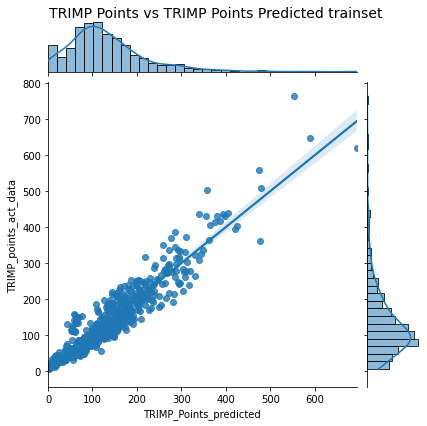

In [485]:
g = sns.jointplot(df_train_full['TRIMP_Points_predicted'], df_train_full['TRIMP_points_act_data'], kind="reg")
g.fig.suptitle('TRIMP Points vs TRIMP Points Predicted trainset', fontsize=14);
g.fig.subplots_adjust(top=0.95) ;

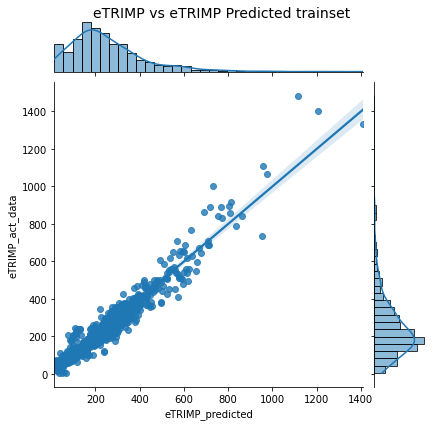

In [488]:
g = sns.jointplot(df_train_full['eTRIMP_predicted'], df_train_full['eTRIMP_act_data'], kind="reg")
g.fig.suptitle('eTRIMP vs eTRIMP Predicted trainset', fontsize=14);
g.fig.subplots_adjust(top=0.95) ;

Now that we have an overall idea on the performance of the models on aggregate data on the _trainset_ we will analyse the results for the test (holdout) set

In [489]:
# predict the two models on the holdout set

df_holdout_full['TRIMP_points_predicted_agg'] = lin_reg_TRIMP_Points.predict(df_holdout_full[['BikeScore','Average_Power','Average_Cadence']])
df_holdout_full['eTRIMP_predicted_agg'] = lin_reg_eTRIMP.predict(df_holdout_full[['BikeScore','Average_Power','Average_Cadence']])

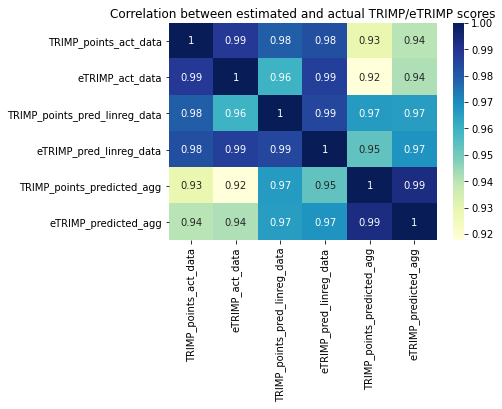

In [491]:
sns.heatmap(df_holdout_full[['filename','TRIMP_points_act_data','eTRIMP_act_data','TRIMP_points_pred_linreg_data','eTRIMP_pred_linreg_data','TRIMP_points_predicted_agg','eTRIMP_predicted_agg']].corr(), annot=True, cmap="YlGnBu")
plt.title('Correlation between estimated and actual TRIMP/eTRIMP scores');

**Observations** 

The correlations between our TRIMP and TRIMP zonal points seems larger with our predicted heart rates coming from our second-by-second (disaggregate) model than using the simple aggregate model we created. Below we show the distributions of the RMSE of the 4 models (two for TRIMP and two for e-TRIMP)

In [497]:
from sklearn.metrics import mean_squared_error

df_rmse_TRIMP = pd.DataFrame()

df_rmse_TRIMP = df_rmse_TRIMP.append(pd.DataFrame(np.array(mean_squared_error(df_holdout_full['TRIMP_points_act_data'], df_holdout_full['TRIMP_points_predicted_agg'],squared=False)).reshape(-1,1)),ignore_index=True)
df_rmse_TRIMP = df_rmse_TRIMP.append(pd.DataFrame(np.array(mean_squared_error(df_holdout_full['TRIMP_points_act_data'], df_holdout_full['TRIMP_points_pred_linreg_data'],squared=False)).reshape(-1,1)),ignore_index=True)
df_rmse_TRIMP = df_rmse_TRIMP.append(pd.DataFrame(np.array(mean_squared_error(df_holdout_full['eTRIMP_act_data'], df_holdout_full['eTRIMP_predicted_agg'],squared=False)).reshape(-1,1)),ignore_index=True)
df_rmse_TRIMP = df_rmse_TRIMP.append(pd.DataFrame(np.array(mean_squared_error(df_holdout_full['eTRIMP_act_data'], df_holdout_full['eTRIMP_pred_linreg_data'],squared=False)).reshape(-1,1)),ignore_index=True)
df_rmse_TRIMP.rename(columns={0:'RMSE'}, inplace=True)

labels =["RMSE_TRIMP_aggregate_model", "RMSE_TRIMP_disaggregate_model", "RMSE_eTRIMP_aggregate_model", "RMSE_eTRIMP_disaggregate_model"]

df_rmse_TRIMP['models'] = labels

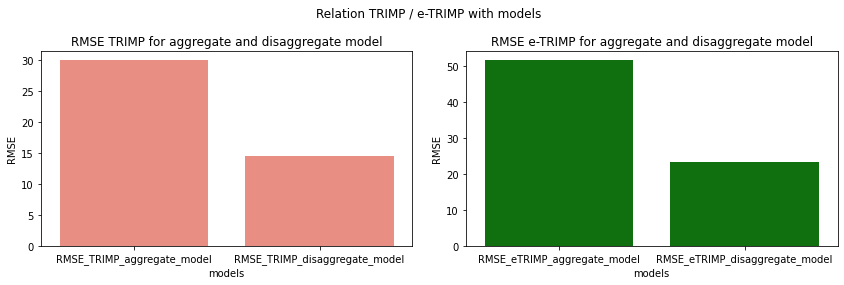

In [498]:
fig, ((ax1, ax2)) = plt.subplots(1, 2,figsize=(12,4))

sns.barplot(x="models", y="RMSE", data=df_rmse_TRIMP[:2], color="salmon", ax=ax1)
ax1.set_title('RMSE TRIMP for aggregate and disaggregate model')
sns.barplot(x="models", y="RMSE", data=df_rmse_TRIMP[2:4], color="green", ax=ax2)
ax2.set_title('RMSE e-TRIMP for aggregate and disaggregate model')
plt.suptitle('Relation TRIMP / e-TRIMP with models', fontweight=18)
plt.tight_layout()

**Observations** 

On our 3 month holdout set calculating TRIMP (and eTRIMP) internal trainingload scores gives more accurate results than predictions using a simple model on aggregate level using aggregate input variables

### Literature

* The heart rate monitor book - Sally Edwards - Google Books http://books.google.com/books?id=ObUUAQAAMAAJ&source=gbs_slider_cls_metadata_9_mylibrary
* Banister EW, Calvert TW, Savage MV, Bach A. A system model of training for athletic performance. Australian Journal of Sports Medicine. 1975;7:170–176.